In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

sns.set_style("ticks")
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("data/cleaned_final_data.csv") # OR USE searchData/limitData
df = df.dropna()
df = df.drop_duplicates()
print(df.dtypes)
df.sample(frac=1).head(5)

year                       int64
month                      int64
region                    object
town                      object
block                     object
street_name               object
lease_commence_date        int64
month_remaining_lease      int64
flat_type                 object
flat_model                 int64
floor_area_sqm           float64
storey_range_low           int64
storey_range_high          int64
nearest_mrt               object
min_dist_mrt             float64
nearest_mall              object
min_dist_mall            float64
min_dist_town_in_km      float64
total_population         float64
cpi                      float64
psi                        int64
resale_price             float64
dtype: object


,year,month,region,town,block,street_name,lease_commence_date,month_remaining_lease,flat_type,flat_model,...,storey_range_high,nearest_mrt,min_dist_mrt,nearest_mall,min_dist_mall,min_dist_town_in_km,total_population,cpi,psi,resale_price
121389,2022,3,west,CHOA CHU KANG,672,CHOA CHU KANG CRESCENT,2000,924,5 ROOM,13,...,12,YEW TEE MRT STATION,0.511829,Yew Tee Square,0.458660,16.813375,1.670454,106.691,30,550000.0
39774,2018,11,north,SEMBAWANG,340B,SEMBAWANG CLOSE,2001,979,4 ROOM,13,...,9,SEMBAWANG MRT STATION,0.300395,Sun Plaza,0.174793,17.478319,1.671586,99.610,39,350000.0
86713,2020,12,north,SENGKANG,468A,FERNVALE LINK,2016,1137,5 ROOM,5,...,24,THANGGAM LRT STATION,0.316258,The Seletar Mall,0.718413,11.913845,1.703850,100.469,52,548000.0
11395,2017,7,north,YISHUN,858,YISHUN AVENUE 4,1988,840,4 ROOM,8,...,3,KHATIB MRT STATION,0.608922,Wisteria Mall,0.313511,13.881683,1.653498,98.726,51,355000.0
67443,2020,2,north,WOODLANDS,825,WOODLANDS STREET 81,1990,832,4 ROOM,8,...,6,WOODLANDS MRT STATION,0.358454,Causeway Point,0.461969,17.591158,1.703850,100.279,32,349000.0


In [3]:
cleaned_df = df.groupby(["year", "month", "town", "flat_type"])[
    'month_remaining_lease', 'floor_area_sqm',
    'storey_range_low', 'storey_range_high',
    'min_dist_mrt', 'min_dist_mall', 'min_dist_town_in_km', 'total_population', 'cpi', 'psi', 'resale_price'].mean()

cleaned_df.reset_index(inplace=True)

/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_47320/635435189.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cleaned_df = df.groupby(["year", "month", "town", "flat_type"])[


month_remaining_lease = 0.024671166339501022
floor_area_sqm = 0.7074726589382774
storey_range_high = 0.03839218388545394
min_dist_town_in_km = 0.1761790777160243
cpi = 0.05328491312074332


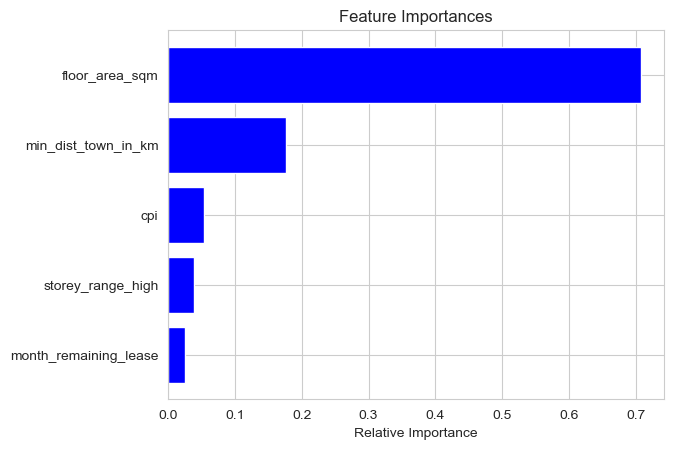

In [12]:

features = ['month_remaining_lease', 'floor_area_sqm', 'storey_range_high','min_dist_town_in_km', 'cpi']
target = "resale_price"
        
X = cleaned_df[features]
y = cleaned_df[target]

rfe = RandomForestRegressor(n_estimators=500, random_state=1)
rfe.fit(X, y)
for name, importance in zip(cleaned_df[features], rfe.feature_importances_):
    print(name, "=", importance)
    
importances = rfe.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [5]:
class RFTimeMode:
    def __init__(self, df, town, flat_type):
        self.town = town
        self.flat_type = flat_type
        self.features = ["year", "month", 'floor_area_sqm', 'min_dist_town_in_km', 'cpi']
        self.target = "resale_price"
        self.scalar = MinMaxScaler()
        
        self.original_df = df.loc[(df['town'] == town) & (df['flat_type'] == flat_type)][self.features + [self.target]]
        self.original_df["date"] = pd.to_datetime(self.original_df[["year", "month"]].assign(DAY=1))
        
        self.df = df.loc[(df['town'] == town) & (df['flat_type'] == flat_type)]
        self.df = self.df[self.features + [self.target]]
        
        self.df = self.normalize(self.df, ['floor_area_sqm', 'min_dist_town_in_km', 'cpi', 'min_dist_mrt', 'resale_price'])
        
        self.X_train,self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.features], self.df[self.target], test_size=0.2, shuffle=False)
    
    def normalize(self, df, cols_to_norm, reversed=False):
        if reversed:
            df[cols_to_norm] = self.scalar.inverse_transform(df[cols_to_norm].values.reshape(-1, 1))
            return df
        else:
            df_prices = df[self.target]
            df[cols_to_norm] = self.scalar.fit_transform(df[cols_to_norm])
            self.scalar.fit_transform(df_prices.values.reshape(-1,1))
            return df
        

    def fit(self, n_estimators= 500, step_size=10):            
        # Get MSE score per epoch
        mse_train = []
        mse_test = []
        epochs = range(1, n_estimators+1, step_size)
        for epoch in epochs:
            RF_Model = RandomForestRegressor(n_estimators=epoch)
            self.rgr=RF_Model.fit(self.X_train[self.features], self.y_train)
            
            y_pred_train = self.rgr.predict(self.X_train)
            y_pred_test = self.rgr.predict(self.X_test)
            mse_train.append(mean_squared_error(self.y_train, y_pred_train))
            mse_test.append(mean_squared_error(self.y_test, y_pred_test))
        
        #plt.plot(epochs, mse_test, label='test')
        plt.plot(epochs, mse_train, label='train')
        plt.xlabel('Epochs')
        plt.ylabel('MSE')
        plt.title('Random Forest Regressor Epochs against MSE for ' + self.town + ' ' + self.flat_type)
        plt.legend()
        plt.show()

    '''
    def pred(self, pred_x_df):
        if set(pred_x_df.columns) != set(self.features):
            raise Exception("Columns do not match")
        predicted_y =  pd.DataFrame(self.rgr.predict(pred_x_df[self.features])).rename(columns={0: "predicted_resale_price"})
        predicted_y = self.normalize(predicted_y, 'predicted_resale_price', reversed=True)
        pred_df = pd.concat([pred_x_df.reset_index(drop=True), predicted_y], axis=1)
        pred_df['date'] = pd.to_datetime(pred_df[["year", "month"]].assign(DAY=1))
        return pred_df
    '''
    
    # walk-forward validation for multivariate data
    def walk_forward_validation(self, n_step, n_trees=500):        
        # Initialize empty array to hold predictions
        n_train = self.X_train.shape[0]
        n_test = self.X_test.shape[0]
        predictions = np.zeros((n_test,))
        
        X = self.df[self.features]
        y = self.df[self.target]
        
        # Create the initial random forest model
        model = RandomForestRegressor(n_estimators=n_trees)
        model.fit(self.X_train, self.y_train)
        
        # Loop over test sets
        for i in range(len(self.X_train), len(X) - n_test, n_step):
            # Make predictions with the model
            y_pred = model.predict(self.X_test)
            # Add the predictions to the output array
            predictions = np.concatenate([predictions, y_pred])
            
            # Update the training set with the current test set
            self.X_train = np.concatenate([self.X_train, X[i:i + n_test, :]])
            self.y_train = np.concatenate([self.y_train, y[i:i + n_test]])
            
            # Fit a new model with the updated training set
            model = RandomForestRegressor(n_estimators=n_trees)
            model.fit(self.X_train, self.y_train)

        
        
        # Return the array of predictions
        return model, predictions
        
    def test(self):
        test_df = self.X_test[self.features].reset_index(drop=True)
        final_df = self.pred(test_df)
        final_df = pd.concat([final_df, self.y_test.reset_index(drop=True)], axis=1)
        final_df = final_df.sort_values(by="date")
        
        # Plot Trend
        plt.figure(figsize=(10, 5))
        data = self.original_df.copy()
        data["date"] = pd.to_datetime(data[["year", "month"]].assign(DAY=1))
        sns.lineplot(data=data, x="date", y="resale_price", label="Actual Resale Price")
        sns.lineplot(data=final_df, x="date", y="predicted_resale_price", label="Precicted Resale Price")
        plt.xticks(rotation=90)
        plt.xlabel("Date")
        plt.ylabel("Resale Price")
        plt.title("Resale Price Trend for {} {}".format(self.town, self.flat_type))
        plt.show()
        
        # Plot Diff
        final_df['diff']=final_df.predicted_resale_price - final_df.resale_price
        final_df['diff'].plot(kind='bar', title="Resale Price Difference for {} {}".format(self.town, self.flat_type))
        
        print("R2:", r2_score(final_df.resale_price, final_df.predicted_resale_price))
        print("MAE:", mean_absolute_error(final_df.resale_price, final_df.predicted_resale_price))
        print("MSE:", mean_squared_error(final_df.resale_price, final_df.predicted_resale_price))
        print("RMSE:", np.sqrt(mean_squared_error(final_df.resale_price, final_df.predicted_resale_price)))
        


In [6]:
town = "WOODLANDS"
flat_type = "4 ROOM"
features = ["year", "month", 'floor_area_sqm', 'min_dist_town_in_km', 'cpi', 'min_dist_mrt']
target = "resale_price"
cols_to_norm = ['floor_area_sqm', 'min_dist_town_in_km', 'cpi', 'min_dist_mrt', 'resale_price']


test_data = cleaned_df.copy()
test_data = test_data.loc[(test_data['town'] == town) & (test_data['flat_type'] == flat_type)][features + [target]]
df_prices = test_data[target]
scalar = MinMaxScaler()
test_data[cols_to_norm] = scalar.fit_transform(test_data[cols_to_norm])
scalar.fit_transform(df_prices.values.reshape(-1,1))

X = test_data[features]
y = test_data[target]

In [7]:
n_test = int(len(test_data) * 0.2)
n_train = len(test_data) - n_test
n_trees = 500
n_step = 1
    
# Create the initial training set
X_train = X.iloc[:n_train, :]
y_train = y.iloc[:n_train]

# Create the initial random forest model
model = RandomForestRegressor(n_estimators=n_trees)
model.fit(X_train, y_train)

X_test_ls = pd.DataFrame()
predictions = np.zeros((n_test,))
# Loop over test sets
for i in range(len(X) - n_test, len(X), n_step):
    # Extract the current test set
    X_test = X.iloc[i:i + n_test, :]

    # Make predictions with the model
    y_pred = model.predict(X_test)
    # Add the predictions to the output array
    prediction = np.concatenate([predictions, y_pred])

    # Append predictions to the test set
    X_test['predicted_resale_price'] = y_pred
    X_test_ls = X_test_ls.append(X_test)

    # Update the training set with the current test set
    X_train = np.concatenate([X_train, X.iloc[i:i + n_test, :]])
    y_train = np.concatenate([y_train, y.iloc[i:i + n_test]])

    # Fit a new model with the updated training set
    model = RandomForestRegressor(n_estimators=n_trees)
    model.fit(X_train, y_train)

/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_47320/3017703388.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['predicted_resale_price'] = y_pred
/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_47320/3017703388.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_ls = X_test_ls.append(X_test)
/Users/jeremychua/opt/anaconda3/envs/tensorflow-env/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/var/folders/dh/hgl_kbnx491bp562snpkpz3r0000gn/T/ipykernel_47320/3017703388.py:27: SettingWithCopyWarning: 
A value is

In [8]:
X_train = pd.DataFrame(X_train, columns=features)
X_test_ls.drop_duplicates(subset="date", keep="first", inplace=True)

X_train["date"] = pd.to_datetime(X_train[["year", "month"]].assign(DAY=1))
X_test_ls["date"] = pd.to_datetime(X_test_ls[["year", "month"]].assign(DAY=1))

train_data = pd.concat([X_train, pd.DataFrame(y_train, columns=["resale_price"])], axis=1)

# Plot X_train against y_train
plt.figure(figsize=(10, 5))
sns.lineplot(data=train_data, x="date", y="resale_price", label="Actual Resale Price")
sns.lineplot(data=X_test_ls, x="date", y="predicted_resale_price", label="Predicted Resale Price")


KeyError: Index(['date'], dtype='object')

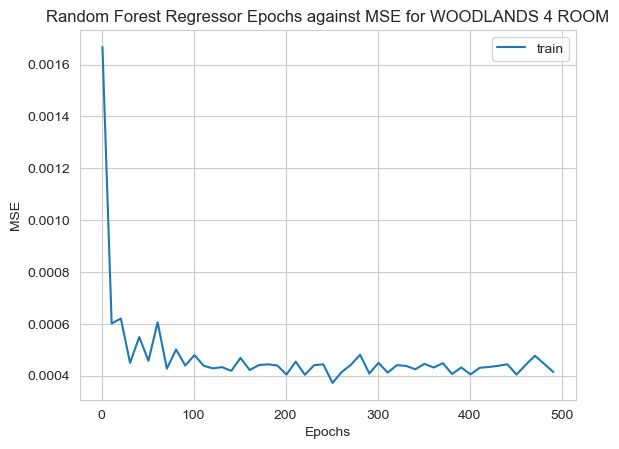

AttributeError: 'RFTimeMode' object has no attribute 'pred'

In [ ]:
test_data = cleaned_df.copy()
model = RFTimeMode(test_data, "WOODLANDS", "4 ROOM")
model.fit()


pred = model.pred(model.df[["year", "month", 'floor_area_sqm', 'min_dist_town_in_km', 'cpi', 'min_dist_mrt']])
pred["date"] = pd.to_datetime(pred[["year", "month"]].assign(DAY=1))
sns.lineplot(data=pred, x="date", y="predicted_resale_price", label="Predicted Resale Price")

test_data = model.original_df.copy()
test_data['date'] = pd.to_datetime(test_data[["year", "month"]].assign(DAY=1))
sns.lineplot(data=test_data, x="date", y="resale_price", label="Actual Resale Price")

In [ ]:
class PredFuture:
    def __init__(self, df, town, flat_type, num_future_months):
        self.town = town
        self.flat_type = flat_type
        self.num_future_months = num_future_months
        self.target = "resale_price"
        
        self.get_model(df)
    
    def get_model(self, df):
        self.model = RFTimeMode(df, self.town, self.flat_type)
        self.model.fit()
        #self.model.test()

    def preprocess_data(self):
        print("Predicting resale price for", self.town, self.flat_type, "flat for the next", self.num_future_months, "months")
        self.model.df["date"] = pd.to_datetime(self.model.df[["year", "month"]].assign(DAY=1))
        latest_date = pd.to_datetime(self.model.df["date"].max()) + pd.DateOffset(months=1)
        new_date = pd.to_datetime(latest_date) + pd.DateOffset(months=self.num_future_months - 1)
        future_df = pd.DataFrame(pd.date_range(start=f'{latest_date}', end=f'{new_date}'), columns=['date'])
        future_df["year"] = future_df["date"].dt.year
        future_df["month"] = future_df["date"].dt.month
        future_df.drop("date", axis=1, inplace=True)
        future_df.drop_duplicates(inplace=True)
        future_df = future_df.reset_index(drop=True)
        features = self.model.features.copy()
        features.remove("year")
        features.remove("month")
        future_df = pd.concat([future_df, self.model.df.sample(n = self.num_future_months).reset_index(drop=True)[features]], axis=1)
        pred_df = self.model.pred(future_df)
        pred_df["town"] = self.town
        pred_df["flat_type"] = self.flat_type
        return pred_df
    
    def plot(self, predicted_df):
        plt.figure(figsize=(10, 5))
        predicted_df = predicted_df.rename(columns={"predicted_resale_price": "resale_price"})
        data = pd.concat([self.model.original_df[['date', 'resale_price']], predicted_df[["date", "resale_price"]]], axis=0)
        sns.lineplot(data=data, x="date", y="resale_price", color="red")
        sns.lineplot(data=self.model.original_df, x="date", y="resale_price", label="Resale Price", color="blue")
        sns.lineplot(data=predicted_df, x="date", y="resale_price", label="Predicted Resale Price", color="red")
        plt.xticks(rotation=90)
        plt.title("Resale Price Trend for {} {}".format(self.town, self.flat_type))
        plt.show()
        
        

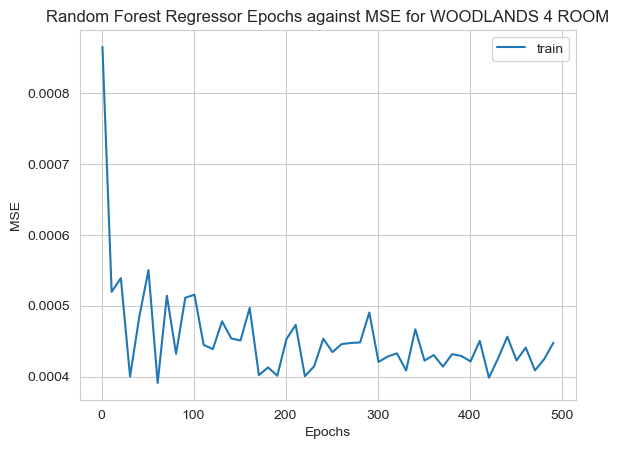

Predicting resale price for WOODLANDS 4 ROOM flat for the next 4 months


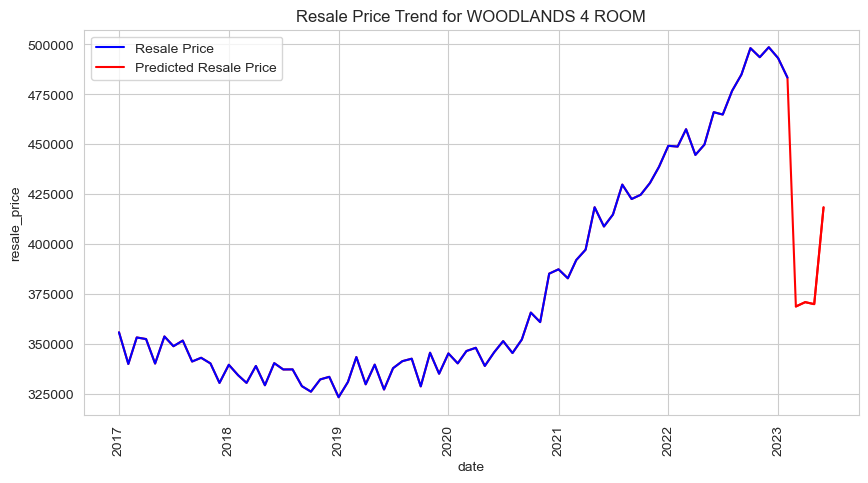

,date,town,flat_type,floor_area_sqm,min_dist_town_in_km,cpi,min_dist_mrt,cpi,predicted_resale_price
0,2023-03-01,WOODLANDS,4 ROOM,0.59444,0.93674,0.03754,0.58726,0.03754,368909.94851
1,2023-04-01,WOODLANDS,4 ROOM,0.77919,0.36767,0.02257,0.00000,0.02257,371086.86889
2,2023-05-01,WOODLANDS,4 ROOM,0.49992,0.55447,0.11683,0.48931,0.11683,370083.90691
3,2023-06-01,WOODLANDS,4 ROOM,0.00000,0.29069,0.84007,0.69023,0.84007,418505.80128


In [ ]:
pred_model = PredFuture(cleaned_df, "WOODLANDS", "4 ROOM", 4)
predicted_df = pred_model.preprocess_data()
pred_model.plot(predicted_df)
predicted_df[['date', 'town', 'flat_type', 'floor_area_sqm', 'min_dist_town_in_km', 'cpi', 'min_dist_mrt', 'cpi',
       'predicted_resale_price']].round(5)

In [ ]:
pred_model.model.df.head(5)

,year,month,floor_area_sqm,min_dist_town_in_km,cpi,min_dist_mrt,resale_price,date
96,2017,1,0.779186,0.367674,0.022568,0.000000,0.185424,2017-01-01
198,2017,2,0.082142,0.587565,0.022343,0.934236,0.094970,2017-02-01
303,2017,3,0.618330,0.479772,0.025427,0.306719,0.170728,2017-03-01
410,2017,4,0.692428,0.410470,0.002708,0.455970,0.166180,2017-04-01
513,2017,5,0.350114,0.834940,0.027985,1.000000,0.096177,2017-05-01
